In [162]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from simdata import HT_sim, scaler,fdd, pdeinp,icinp,bcinp


In [163]:
L = 15e-3

time_end = 5.0
numpoints = 50
t_surr = 500.0
temp_init = 919.0



In [164]:
heat_data = HT_sim(L, time_end, numpoints,  t_surr,temp_init)
alpha = heat_data.alpha_l
print(alpha)
tempfield = heat_data.datagen()
print(tempfield.shape)

3.394878564540885e-05
(3935, 50)


In [165]:

# heat_data.plot_temp(25)
x_c = 1/L
t_c = (alpha/(L**2))
temp_c = 919.0

# Temperature dataset
temp_data = tempfield.flatten()

temp_data = temp_data*(1.0/919.0)

# temp_data = scaler(temp_data,400.0,919.0)


# input dataset- fdd
num_steps = tempfield.shape[0]
numpoints = tempfield.shape[1] 
print(numpoints, num_steps)
print(numpoints*num_steps) 
inp_data = fdd(L, time_end, numpoints, num_steps,scl="false")



50 3935
196750


In [166]:
def pde(x, y):
    # pde for heat equation
    dy_t = dde.grad.jacobian(y, x, j=0)
    dy_xx = dde.grad.hessian(y, x, j=1)
    return dy_t - dy_xx

def scale2(x,x_c,t_c):
    x[:,0] = x[:,0] * x_c
    x[:,1] = x[:,1] * t_c
    return x

In [167]:
geom = dde.geometry.Interval(0, (L*x_c))

timedomain = dde.geometry.TimeDomain(0, (time_end*t_c))
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.DirichletBC(geomtime, lambda x: (500.0/919.0), lambda _, on_boundary: on_boundary)

ic = dde.IC(geomtime, lambda x: (919.0/919.0), lambda _, on_initial: on_initial)

In [168]:
data = dde.data.TimePDE(geomtime, \
                        pde,\
                        [bc, ic], \
                      num_domain=30000, \
                     num_boundary=500, \
                        num_initial=500, num_test=10000)

In [169]:
net = dde.maps.FNN([2] + [30] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)



In [170]:
model.compile("adam", lr=0.0001)



losshistory, train_state = model.train(iterations=18000)

Compiling model...
Building feed-forward neural network...
'build' took 0.016643 s

'compile' took 0.247486 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [5.59e-01, 2.39e-01, 3.88e-01]    [5.64e-01, 2.39e-01, 3.88e-01]    []  
1000      [8.41e-04, 3.17e-02, 8.87e-03]    [8.12e-04, 3.17e-02, 8.87e-03]    []  
2000      [1.17e-03, 3.02e-02, 7.54e-03]    [1.11e-03, 3.02e-02, 7.54e-03]    []  
3000      [1.07e-03, 2.38e-02, 5.89e-03]    [9.87e-04, 2.38e-02, 5.89e-03]    []  
4000      [1.89e-03, 1.43e-02, 2.18e-03]    [1.83e-03, 1.43e-02, 2.18e-03]    []  
5000      [5.84e-04, 1.31e-02, 1.52e-03]    [5.77e-04, 1.31e-02, 1.52e-03]    []  
6000      [4.09e-04, 1.04e-02, 1.36e-03]    [3.73e-04, 1.04e-02, 1.36e-03]    []  
7000      [2.93e-04, 7.49e-03, 1.23e-03]    [2.51e-04, 7.49e-03, 1.23e-03]    []  
8000      [1.65e-04, 5.15e-03, 8.86e-04]    [1.46e-04, 5.15e-03, 8.86e-04]    []  
9000      [9.10e-05, 4.30e-03, 6.

(196750, 1)
(3935, 50)


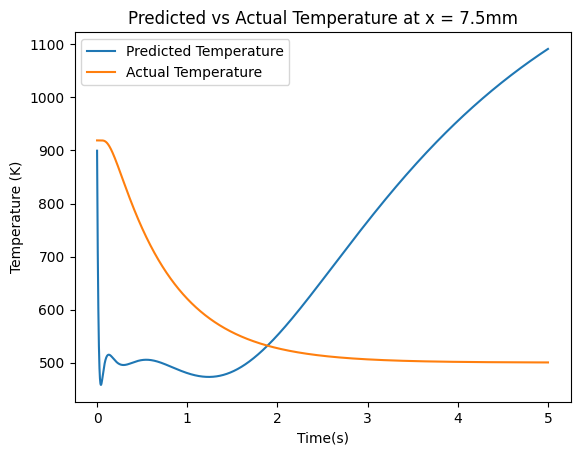

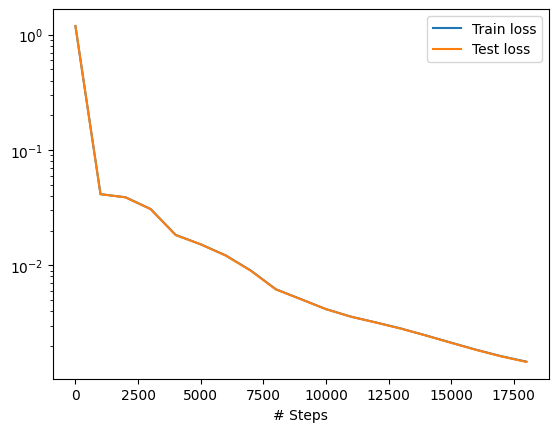

In [171]:
y_pred = model.predict(inp_data)

y_pred = y_pred * 919.0

print(y_pred.shape)
temp_nn = y_pred.reshape(num_steps, numpoints)
print(temp_nn.shape)
time_ss= np.linspace(0, time_end, num_steps )

plt.figure
plt.plot(time_ss, temp_nn[:,24 ], label='Predicted Temperature')
plt.plot(time_ss, tempfield[:,24], label='Actual Temperature')
plt.xlabel('Time(s)')
plt.ylabel('Temperature (K)')
plt.yscale('linear')
plt.title('Predicted vs Actual Temperature at x = 7.5mm')
plt.legend()
plt.show()

dde.utils.external.plot_loss_history(losshistory)